### TODO:

- Run every method on the same test set and compare
- do more systematic caching - would be helpful for clearer code (use function or global variable)
- to the best model add generated features (user age and hour of accident)
- run SVM and KNN on dataset obtrained from downsampling - on LR tested that it gives the same results as big one
- try to compare auc curves - probably these will overlap fully for all created models but we can try
- analysis of roc curve and crosstabs - for the best model
- from logistic regression docs: Note that regularization is applied by default (sic!) - test different regularization parameters for LR DONE


## Outline

NOTE: the most resource-extensive chunks are cached in folder models_cache. To run all chunks, set NEW_CACHE variable below to True, and if you want to load from cache folder - False

### Preparation

In [1]:
NEW_CACHE = False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import pickle


pd.set_option("display.max_columns",200)

def print_value_counts(df):
    for i in df.columns:
        print(f'column: {i}')
        display(df[i].value_counts())
        print()

In [3]:
x_train = pd.read_pickle('data/x_train.pkl')
y_train = pd.read_pickle('data/y_train.pkl')

x_test = pd.read_pickle('data/x_test.pkl')
y_test = pd.read_pickle('data/y_test.pkl')

minfos_df = pd.read_pickle('data/minfos_df.pkl')

## Modeling

### GLM with adding features from mutual info

Running kfold cross validation, with recursive feature selection. Features are added one by one, ordered by mutual info. Using caching here as it's running for long - just run next cell.

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

if NEW_CACHE:
# if True:
    scores = []

    for no_features_to_include in range(1,30):
        if no_features_to_include % 5 == 1:
            # trick to control number of features selected 
            print('running ', no_features_to_include)
        features = list(minfos_df.head(no_features_to_include).column)
        r2_train = []
        r2_test = []

        for train, test in kf.split(x_train.index.values):
            reg = LogisticRegression()
            reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])

            predsTrain = reg.predict_proba(x_train.iloc[train][features])
            preds = reg.predict_proba(x_train.iloc[test][features])

            r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
            r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

        a = (no_features_to_include, np.mean(r2_test), np.mean(r2_train))
        scores.append(a)    
    #     print(a)
    roc_scores_lr = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
    roc_scores_lr.to_pickle('models_cache/roc_scores_lr_from_minfo.pkl')


running  1
running  6
running  11
running  16
running  21
running  26


Note: above cell is cached and read below, no nneed to re-run

In [4]:
roc_scores_lr = pd.read_pickle('models_cache/roc_scores_lr_from_minfo.pkl')

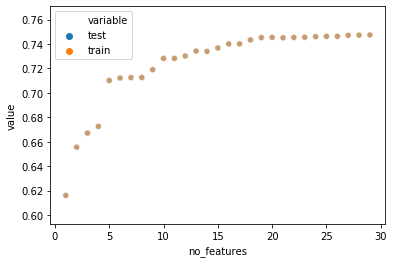

In [5]:
sns.scatterplot(x = 'no_features', y= 'value', hue = 'variable', alpha = 0.5, data = pd.melt(roc_scores_lr, id_vars = 'no_features'))

The above plot shows that train and test scores overlap almost fully - that means that logistic regression is very resilient to overfitting as it didn't occur at all in this case

Best value of AUC is around 0.74. After adding 20 features the outcome is not changing significantly. Now I'm fitting model with that amount of features to obtain true outcome on the held-out test set. 

In [6]:
features = list(minfos_df.head(20).column)
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7454278485472715
AUC for test set  0.7148965376034546


Value of AUC for test set is 0.714 - drop from train set is really small

### GLM model with all features

In [7]:
mod = sm.GLM(y_train['y'],x_train,family = sm.families.Binomial())
res= mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               778013
Model:                            GLM   Df Residuals:                   777960
Model Family:                Binomial   Df Model:                           52
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7712e+05
Date:                Mon, 08 Jun 2020   Deviance:                   7.5424e+05
Time:                        21:54:16   Pearson chi2:                 7.82e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
d_lighting_Night with public lighting on                          0.2030      0.008     23.904      0.000       0.186       0.220
d_lighting_Night without public lighting                          0.3309      0.011     31.056      0.000       0.310       0.352
d_lighting_Twilight or dawn                                       0.1342      0.012     11.090      0.000       0.111       0.158
d_localization_Out of agglomeration                               0.7764      0.008     96.584      0.000       0.761       0.792
d_intersection_type_Intersection in T                            -0.0698      0.015     -4.567      0.000      -0.100      -0.040
d_intersection_type_Intersection in X                            -0.1293      0.014     -9.002      0.000      -0.157      -0.101
d_intersection_type_Out of intersection                           0.1598      0.012     13.514      0.000       0.137       0.183
d_weather_Heavy rain                                             -0.0699      0.023     -3.061      0.002      -0.115      -0.025
d_weather_Light rain                                             -0.2314      0.016    -14.763      0.000      -0.262      -0.201
d_weather_Normal                                                 -0.1357      0.012    -11.297      0.000      -0.159      -0.112
d_collision_type_Other collision                                 -0.3442      0.556     -0.619      0.536      -1.433       0.745
d_collision_type_Three or more vehicles - multiple collisions    -0.8251      0.556     -1.484      0.138      -1.915       0.264
d_collision_type_Three vehicles and more - in chain              -1.4944      0.556     -2.686      0.007      -2.585      -0.404
d_collision_type_Two vehicles - by the side                      -0.4555      0.556     -0.820      0.412      -1.545       0.634
d_collision_type_Two vehicles - from the rear                    -0.8286      0.556     -1.491      0.136      -1.918       0.261
d_collision_type_Two vehicles - frontal                          -0.1020      0.556     -0.184      0.854      -1.191       0.987
d_collision_type_Without collision                                0.0099      0.556      0.018      0.986      -1.079       1.099
d_road_category_Departmental Road                                 0.6500      0.007     87.519      0.000       0.635       0.665
d_road_category_Highway                                          -0.0232      0.015     -1.505      0.132      -0.053       0.007
d_road_category_National Road                                     0.3812      0.011     33.306      0.000       0.359       0.404
d_road_regime_NA                                                 -0.1170      0.013     -8.77

In [8]:
prob = res.predict()
preds = np.array([1 if x<0.5 else 0 for x in prob])
pd.crosstab((y_train['y']),preds)

col_0,0,1
y,,
0,33337,545874
1,56729,142073


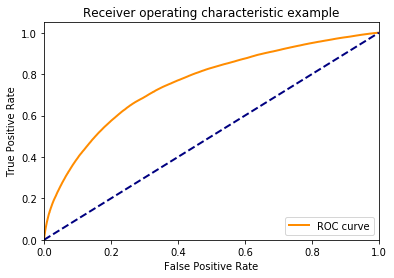

In [9]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train.y, res.predict())
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()

### Modeling with SVM - small set, 20 best features from mutual info

As the dataset is huge - using SVM with other kernel than linear is out of question. Running it on 2 features only, with radial kernel, would take >10 minutes. That is why I have used linear kernel only. Linear kernel is still infeasible to run on the full dataset. Main train dataset has ~7 mln observations, fitting linear svm becomes infeasible at 100 000 obs - at 10 000 the speed is acceptable.

In [7]:
from sklearn.svm import SVC

Reducing train set size - the same random state in x and y gives proper observations

In [8]:
x_train_small = x_train.sample(n = 10000, random_state = 42)
y_train_small = y_train.sample(n = 10000, random_state = 42)

Running SVM on default parameters, best 20 features obtained before are selected.

In [12]:
features = list(minfos_df.head(20).column)
reg = SVC(kernel = 'rbf', probability = True)
reg.fit(x_train_small[features], y_train_small['y'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
# predsTest = reg.predict_proba(x_test[features])

# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

Above takes very long to run - AUC on test set was 0.625, lower than the best model from logistic regression (0.715)

SVM with 20 features - finding the best C

Trying to find the best c value on the smaller train set with 10 000 observations - obtained above. Number of features is set at 20, as this was correct number shown by Logistic Regression. Again, the kernel is linear.

In [15]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'linear', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_svm.to_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [11]:
roc_scores_svm = pd.read_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

ValueError: unsupported pickle protocol: 5

In [17]:
roc_scores_svm

NameError: name 'roc_scores_svm' is not defined

Performance did not improve much - best value was for c = 1.5, and result obtained for test set from cross validation was 0.699. Using the same procedure, fitting SVM with rbf kernel.

In [18]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'rbf', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm_rbf = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
# roc_scores_svm_rbf.to_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [19]:
roc_scores_svm_rbf = pd.read_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

ValueError: unsupported pickle protocol: 5

In [20]:
roc_scores_svm_rbf

NameError: name 'roc_scores_svm_rbf' is not defined

Performance using radial kernel got even worse than using linear kernel.

### SVM with 20 features using Stochastic Gradient Descent - finding the best C

Using SGDClassifier with 'hinge' loss, it is equivalent to running standard SVM classifier, but allows for parallel computing. This allows for using full set for training.

In SGD there is parameter alpha performing the regularization. Its relation to c in SVM function is C_svc * n_samples = 1 / alpha_sgd

alpha_sgd = 1 / (C_svc * n_samples)

https://stats.stackexchange.com/questions/216095/how-does-alpha-relate-to-c-in-scikit-learns-sgdclassifier


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [13]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1)
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [14]:
predsTest = calib_model.predict_proba(x_test[features])
print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7454278485472715
AUC for test set  0.6910450266654722


In [24]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train.index.values):
#         n_samples = x_train.iloc[train][features].shape[0]
#         alpha_sgd = 1 / (c * n_samples)
# #         print('computed alpha:', alpha_sgd)
        
#         reg = SGDClassifier(n_jobs = -1, alpha = alpha_sgd)
#         reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         calibrator = CalibratedClassifierCV(reg, cv='prefit')
#         calib_model =calibrator.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         predsTrain = calib_model.predict_proba(x_train.iloc[train][features])
#         preds = calib_model.predict_proba(x_train.iloc[test][features])
        
#         r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_sgd = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_sgd.to_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

In [15]:
roc_scores_sgd = pd.read_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

ValueError: unsupported pickle protocol: 5

In [26]:
roc_scores_sgd

NameError: name 'roc_scores_sgd' is not defined

Best alpha is 2.0. Now fitting to the full dataset and checking GOF for test set.

In [16]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1,alpha = 1/(1.5*x_train.shape[0]))
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [17]:
predsTrain = calib_model.predict_proba(x_train[features])
predsTest = calib_model.predict_proba(x_test[features])
print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7336213906677659
AUC for test set  0.7035621047261944


Not much improvement over the LR

### Feature generation

#### Using features that looked promising from EDA

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
cols_to_log = [
 'd_lighting_Night without public lighting',
 'd_lighting_Twilight or dawn',
 'd_localization_Out of agglomeration',
 'd_intersection_type_Out of intersection',
 'd_weather_Normal',
 'd_collision_type_Other collision',
 'd_collision_type_Two vehicles - frontal',
 'd_collision_type_Without collision',
 'd_road_category_Departmental Road',
 'd_road_regime_One way',
 'd_road_regime_Separated carriageways',
 'd_reserved_lane_NA',
 'd_road_gradient_NA',
 'd_road_plan_NA',
 'd_road_plan_Straight part',
 'd_road_condition_normal',
 'd_road_condition_wet',
 'd_accident_situation_On the verge',
 'd_place_in_car_1',
 'd_place_in_car_NA',
 'd_user_type_Pedestrian',
 'd_equipment_used_no',
 'd_pedestrian_action_not specified or not applicable',
 'd_pedestrian_alone_NA',
 'hour',
 'user_age'
 ]

features = cols_to_log
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7426305379192165
AUC for test set  0.7095022917246666


Value of AUC using features selected by hand is a little bit smaller than using 20 best features from mutual info. Now trying if binning continuous variables will help, as it looked promising in the EDA part.

In [19]:
features = list(minfos_df.head(20).column) + ['hour', 'user_age']
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7448112387381813
AUC for test set  0.7147741229989997


#### Binning categorical variables - user age

In [20]:
temp_age = pd.concat([x_train[['user_age']], y_train['y']], axis=1)

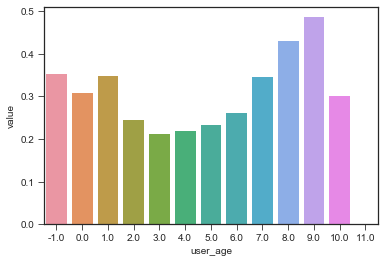

In [21]:
a = pd.crosstab(temp_age['user_age']//10, columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['user_age'], value_vars=[0, 1])

b

sns.barplot(x = 'user_age', y = 'value', data = b.query('y==1'))

The plot above presents percentage of people at given age who were killed. As can be seen there is some regularity - very young and very old people are more likely to die. 

#### Benchmark

In [22]:
features = list(minfos_df.head(20).column) + ['user_age']

x_train_age = x_train.copy()
x_train_age['user_age'] = x_train_age['user_age']

x_test_age = x_test.copy()
x_test_age['user_age'] = x_test['user_age']

reg = LogisticRegression()
reg.fit(x_train_age[features], y_train['y'])

predsTrain = reg.predict_proba(x_train_age[features])
predsTest = reg.predict_proba(x_test_age[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7447119092345647
AUC for test set  0.7143325980115898


#### Finding the best bin width

In [34]:
features = list(minfos_df.head(20).column) + ['user_age']

for bin_width in [10, 15, 20, 25, 30]:
    print('testing bin width of:', bin_width)
    x_train_age = x_train[features].copy()
    x_train_age['user_age'] = x_train_age['user_age']//bin_width
    x_train_age = pd.concat([x_train_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_train_age['user_age'],drop_first = 1)], axis = 1)

    x_test_age = x_test[features].copy()
    x_test_age['user_age'] = x_test_age['user_age']//bin_width
    x_test_age = pd.concat([x_test_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_test_age['user_age'],drop_first = 1)], axis = 1)


    reg = LogisticRegression()
    reg.fit(x_train_age, y_train['y'])

    predsTrain = reg.predict_proba(x_train_age)
    predsTest = reg.predict_proba(x_test_age)

    print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
    print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))



testing bin width of: 10
AUC for train set  0.7516859938374751
AUC for test set  0.7209365363002047
testing bin width of: 15
AUC for train set  0.7487820218653708
AUC for test set  0.719124021986697
testing bin width of: 20
AUC for train set  0.7506147594214568
AUC for test set  0.7187326427592574
testing bin width of: 25
AUC for train set  0.749394219408045
AUC for test set  0.718888068021157
testing bin width of: 30
AUC for train set  0.7480844639130837
AUC for test set  0.7179906580269504


Small improvement!

Benchmark:

- AUC for train set  0.7436704000408136
- AUC for test set  0.7163762566270527



Adding age variable with bin width of 10 really gave an improvement (0.0003 on AUC but still) 

#### Feature generation - hour of accident

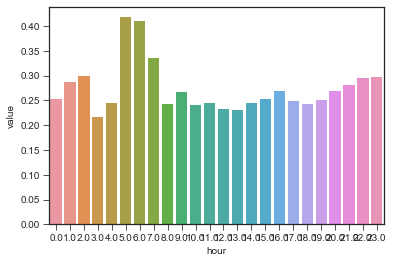

In [23]:
temp_h = pd.concat([x_train[['hour']], y_train['y']], axis=1)
a = pd.crosstab(temp_h['hour'], columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['hour'], value_vars=[0, 1])

b

sns.barplot(x = 'hour', y = 'value', data = b.query('y==1'))

Worst hours are 5, 6 and 7.

#### Putting all hours as dummies

In [24]:
features = list(minfos_df.head(20).column) + ['hour']


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7464482450114094
AUC for test set  0.715530386929031


Even with all hours present the results are better than without them!

#### Dropping irrelevant hours (judging from the plot above)

In [25]:
features = list(minfos_df.head(20).column) + ['hour']
hours_to_drop = [5,6]


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)
x_train_h.drop(hours_to_drop, axis = 1, inplace = True)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)
x_test_h.drop(hours_to_drop, axis = 1, inplace = True)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7463987752472732
AUC for test set  0.715508210052707


In [26]:
x_train_h = x_train[features].copy()
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)
x_train_h.drop(hours_to_drop, axis = 1, inplace = True)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)
x_test_h.drop(hours_to_drop, axis = 1, inplace = True)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

C:\Users\bugra.duman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
AUC for train set  0.7463987752472732
AUC for test set  0.715508210052707


Testing the approach with variable if_morning - for hours 5,6. Did not give improvement.

In [39]:
# features = list(minfos_df.head(20).column) + ['hour']

# x_train_h = x_train[features].copy()
# x_train_h['if_morning'] = x_train_h['hour'].between(5,6).astype(int)
# x_train_h = x_train_h.drop('hour', axis= 1)

# x_test_h = x_test[features].copy()
# x_test_h['if_morning'] = x_test_h['hour'].between(5,6).astype(int)
# x_test_h = x_test_h.drop('hour', axis= 1)

# reg = LogisticRegression()
# reg.fit(x_train_h, y_train['y'])

# predsTrain = reg.predict_proba(x_train_h)
# predsTest = reg.predict_proba(x_test_h)

# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

### Imbalance methods

In [27]:
x_train.shape

(778013, 53)

The dataset is slightly imbalanced. Only 23% of people involved in the accidents were seriously injured or killed. That is why we have decided to include methods for fighting this imbalance. The dataset is very big - with around 80 000 observations in train set. That is why undersampling seems a good choice. It will be also faster to test more possible combinations.

#### Benchmark

In [28]:
features = list(minfos_df.head(20).column)
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7454278485472715
AUC for test set  0.7148965376034546


#### Downsampling to obtain 50/50 distribution of 0s nad 1s

In [29]:
y_train.y.value_counts()

0    579211
1    198802
Name: y, dtype: int64

For perfect imbalance we need to drop 381150 instances with y=0.

In [30]:
from random import shuffle
trainIndex0 = list(y_train.query("y==0").index.values)
shuffle(trainIndex0)

In [31]:
x_train_u = x_train.drop(trainIndex0[0:381150])
y_train_u = y_train.drop(trainIndex0[0:381150])

In [32]:
print(y_train_u.y.value_counts())
print(x_train_u.shape)

1    198802
0    198061
Name: y, dtype: int64
(396863, 53)


In [33]:
features_u = list(minfos_df.head(20).column)
reg_u = LogisticRegression()
reg_u.fit(x_train_u[features_u], y_train_u['y'])

predsTrain = reg_u.predict_proba(x_train_u[features_u])
predsTest = reg_u.predict_proba(x_test[features_u])

print("AUC for train set " , roc_auc_score(y_train_u.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7464558549542701
AUC for test set  0.7152245078441722


Downsampling improved the results on the test set by small amount. 

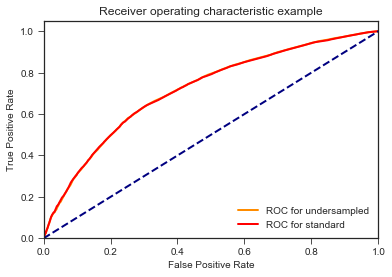

In [34]:
from sklearn.metrics import roc_curve
fpr_u, tpr_u, _ = roc_curve(y_test.y, reg_u.predict_proba(x_test[features_u])[:,1])
fpr, tpr, _ = roc_curve(y_test.y, reg.predict_proba(x_test[features])[:,1])
plt.figure()
lw = 2
plt.plot(fpr_u, tpr_u, color='darkorange',
         lw=lw, label='ROC for undersampled')
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC for standard')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()

ROC with and without resampling are essentially the same.

Note: 95918 observations 50/50 are enought to create the same accuracy.

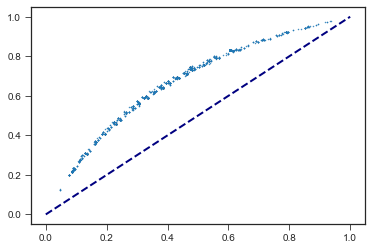

In [35]:
plt.scatter(reg.predict_proba(x_test[features])[:2000,1], reg_u.predict_proba(x_test[features_u])[:2000,1], s=0.2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

This picture shows predicted probability by 2 models for saample of observations. On axis x there is standard model, while on axis y - with downsampling. As can be seen, downsampling actually caused systematically bigger probability of obtaining 1.

More fancy methods for resampling take a very long time to run. or actually can't run them on such big dataset.

In [49]:
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import ClusterCentroids 

# cc = ClusterCentroids(random_state=42,sampling_strategy=0.5,n_jobs = -1)
# x_train_cl, y_train_cl = cc.fit_resample(x_train, y_train)

In [50]:
# from imblearn.under_sampling import TomekLinks

# cc = TomekLinks(n_jobs = -1)
# x_train_cl, y_train_cl = cc.fit_sample(x_train, y_train)

### KNN modeling

In [36]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors

In [37]:
x_train_small = x_train.sample(n = 100000, random_state = 42)
y_train_small = y_train.sample(n = 100000, random_state = 42)

In [53]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# ks = [5, 50, 100]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for k in ks:
#     print('running for k: ', k)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):

#         reg = neighbors.KNeighborsClassifier(k, n_jobs=-1, p=2)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])

#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (k, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# roc_scores_knn = pd.DataFrame(scores, columns = ['k', 'test', 'train'])
# roc_scores_knn.to_pickle('models_cache/roc_scores_knn_from_minfo.pkl')

In [41]:
roc_scores_knn = pd.read_pickle('models_cache/roc_scores_knn_from_minfo.pkl')

ValueError: unsupported pickle protocol: 5

In [55]:
roc_scores_knn

NameError: name 'roc_scores_knn' is not defined

In [56]:
# predsTest = reg.predict_proba(x_test[features].iloc[:30000, :])
# # print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.iloc[:30000, :].y, predsTest[:,1]))

Auc for test set: 0.66155778766371

### Testing other models

Main findings from above process we applied are:

- The 20 best features from mutual information perform the best both with svm na LR
- Adding age variable with bin width of 10 improves the result by small amount.
- Hour variable treated as 23 dummies gives improvement. However, limiting number of variables resulted in fail - the improvement is visible only with 20 dummies. Also it is very small (AUC +0.001) This number of features is unacceptable (there are 20 other features). So we are dropping this idea. 
- SVM can be approvimated by Stochastic Gradient Descent - the only way to run SVM on such big dataset. 
- KNN did not perform very well and is very resource extensive 

- Downsampling to obtain 50/50 0s and 1s counts did not improve the score, but also did not worsen. We can use smaller dataset to facilitate later testing.

TODO:

Use these methods on downsampled dataset with 20 features from mutual info and added age variable with bin width of 10:

- SVM using SGD - try finding better C
- Logistic regression - test regularization parameters, as previously was tested with c=1.0 (default of sklearn function)

In [38]:
from random import shuffle
trainIndex0 = list(y_train.query("y==0").index.values)
shuffle(trainIndex0)

features = list(minfos_df.head(20).column) + ['user_age']

x_train_u = x_train.drop(trainIndex0[0:381150])
y_train_u = y_train.drop(trainIndex0[0:381150])

bin_width = 10

x_train_t = x_train_u[features].copy()
x_train_t['user_age'] = x_train_t['user_age']//bin_width
x_train_t = pd.concat([x_train_t.drop('user_age', axis = 1), 
                         pd.get_dummies(x_train_t['user_age'],drop_first = 1)], axis = 1)

y_train_t = y_train_u.copy()

In [39]:
print(x_train_t.shape)
print(y_train_t.shape)

(396863, 31)
(396863, 1)


In [40]:
x_test_t = x_test[features].copy()
x_test_t['user_age'] = x_test_t['user_age']//bin_width
x_test_t = pd.concat([x_test_t.drop('user_age', axis = 1), 
                         pd.get_dummies(x_test_t['user_age'],drop_first = 1)], axis = 1)

x_test_t = x_test_t.drop(11, axis = 1)
y_test_t = y_test.copy()

In [41]:
print(x_test_t.shape)
print(y_test_t.shape)

(1604922, 31)
(1604922, 1)


In [59]:
reg_t = LogisticRegression(max_iter = 1000)
reg_t.fit(x_train_t, y_train_t['y'])

predsTrain = reg_t.predict_proba(x_train_t)
predsTest = reg_t.predict_proba(x_test_t)

print("AUC for train set " , roc_auc_score(y_train_t.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test_t.y, predsTest[:,1]))

AUC for train set  0.7517791944161715
AUC for test set  0.7209384390003034


Improvement from 0.714! 

Testing logistic regression with different regularization parameter C. We're using GridSearch function istead of custom one as it allows for parallelization of fitting for all parameters.

In [62]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

reg_grid = LogisticRegression(max_iter = 1000)

grid_params = {
    'C': [0.01, 0.1, 0.5, 1, 2, 5]
}

gs =GridSearchCV(reg_grid,grid_params,verbose=1,cv=3,n_jobs=-1)

gs_results = gs.fit(x_train_t, y_train_t['y'])

gs_results.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   56.9s finished


{'C': 0.01}

Best parameter chosen with regularization on big range is 1. Now trying to test values closer to 1.

In [63]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

reg_grid = LogisticRegression(max_iter = 1000)

grid_params = {
    'C': [0.8, 0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1, 1.2]
}

gs =GridSearchCV(reg_grid,grid_params,verbose=1,cv=3,n_jobs=-1)
gs_results = gs.fit(x_train_t, y_train_t['y'])
gs_results.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.6min finished


{'C': 1.1}

In [64]:
gs_results.cv_results_

{'mean_fit_time': array([12.5485429 , 13.67826358, 16.04364777, 14.67181619, 14.05034256,
        11.73897823, 12.7377704 , 13.07026235, 12.12710508]),
 'std_fit_time': array([4.39776551, 4.11051671, 3.52128713, 3.75498226, 3.23255799,
        3.10098876, 4.86676374, 3.87281359, 2.98219698]),
 'mean_score_time': array([0.15391668, 0.16557511, 0.18323843, 0.16058222, 0.15758133,
        0.15891576, 0.13393068, 0.13859113, 0.11826762]),
 'std_score_time': array([0.02941866, 0.01685066, 0.02002858, 0.0226794 , 0.02712074,
        0.01605476, 0.01357831, 0.00464166, 0.03496994]),
 'param_C': masked_array(data=[0.8, 0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1, 1.2],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.8},
  {'C': 0.9},
  {'C': 0.95},
  {'C': 0.98},
  {'C': 1},
  {'C': 1.02},
  {'C': 1.05},
  {'C': 1.1},
  {'C': 1.2}],
 'split0_test_score': array([0.68567822, 0.

Again, c=1 looks like the best candidate. We can't improve further from that point with Logistic Regression.

SGD with balanced data

In [50]:
from sklearn.linear_model import SGDClassifier

reg_r = SGDClassifier(n_jobs=-1,alpha=1/(1.5*x_train_t.shape[0])
reg_r.fit(x_train_t,y_train_t)


cali = CalibratedClassifierCV(reg_sgd,cv="prefit")
cali_model =cali.fit(x_train_t, y_train_t)

Pred_SGD_train = cali_model.predict_proba(x_train_t)
Pred_SGD_test = cali_model.predict_proba(x_test_t)
print(roc_auc_score(y_train_t.y,Pred_SGD_train[:,1]))
print(roc_auc_score(y_test_t.y,Pred_SGD_test[:,1]))


SyntaxError: invalid syntax (<ipython-input-50-831403180292>, line 4)

KNN with balanced data

In [51]:
x_train_t_small = x_train_t.sample(n = 200000,random_state=42)
y_train_t_small = y_train_t.sample(n = 200000, random_state = 42)

Plotting

In [ ]:
# plt.scatter(reg_r.predict_proba(x_test_t)[:2000,1], reg_k.predict_proba(x_test_t)[:2000,1], s=0.2)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.subplot(1,3,1)
# plt.scatter(reg_t.predict_proba(x_test_t)[:2000,1], reg_k.predict_proba(x_test_t)[:2000,1], s=0.2)
# plt.subplot(1,3,2)
# plt.scatter(reg_t.predict_proba(x_test_t)[:2000,1], reg_r.predict_proba(x_test_t)[:2000,1], s=0.2)
# plt.subplot(1,3,3)

broooo that shitty KNN did not run with small one on my notebook ı dont know why like nothing happened at all after running the cell can you run it when u open your nice cloud :)